In [4]:
import sys, os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [6]:
#import pyOptimalEstimation as pyOE
sys.path.append('../smrt/smrt-master/smrt')
#from utils import tiepoint

from smrt import utils

In [7]:
use_module = False
if use_module:
    from utils import get_data_var_from_netCDF
else:
    var_name_tabel = """Posible data variables: 
    lat: TLAT 
    lon: TLON 
    snow thickness: hs
    ice thickness: hi
    snow surface temperature: Tsfc
    Ice type: FYarea"""

    def get_data_var_from_netCDF(f_path = None, var_name = None, coords = None):
        # If no varable name is given, print the possibilities
        if (var_name == None) | (f_path == None):
            print('usage: get_data_var_from_netCDF(f_path = [file path], var_name = [variable name], <coords = [j, i]>)\n')
            print(var_name_tabel)
            return
        # If a set of coordinates is given, return the indexed data point
        if coords:
            if isinstance(coords, list):
                # converting list to array
                coords = np.array(coords)
                return xr.open_dataset(f_path)[var_name].values[tuple(coords)]
            else:
                print("Variable 'coords' must be of type 'list'. E.g.: coords = [1,2]")
        # If no coordinates are given, return the full data array
        else:
            return xr.open_dataset(f_path)[var_name].values

In [8]:
# Path to data file
f_path = "../Data/iceh.2011-01.nc"
get_data_var_from_netCDF()

usage: get_data_var_from_netCDF(f_path = [file path], var_name = [variable name], <coords = [j, i]>)

Posible data variables: 
    lat: TLAT 
    lon: TLON 
    snow thickness: hs
    ice thickness: hi
    snow surface temperature: Tsfc
    Ice type: FYarea


In [9]:
# Get data array
get_data_var_from_netCDF(f_path = f_path, var_name = 'hi')

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [10]:
data = np.squeeze(get_data_var_from_netCDF(f_path = f_path, var_name = 'hisnap'))

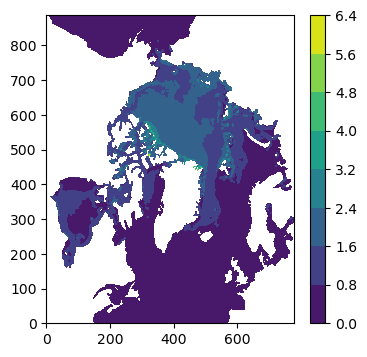

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
cs = ax.contourf(data);
fig.colorbar(cs)

In [20]:
st = get_data_var_from_netCDF(f_path = f_path, var_name = 'Tsnz')
st[1]

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [38]:
# Get data array
st = get_data_var_from_netCDF(f_path = f_path, var_name = 'Tsnz')[0] + 273.15 # 0 is highest and 4 is lowest
sd = get_data_var_from_netCDF(f_path = f_path, var_name = 'hs')
id = get_data_var_from_netCDF(f_path = f_path, var_name = 'hi')
ic = get_data_var_from_netCDF(f_path = f_path, var_name = 'aice')
# Set ice type
ice_type = 'firstyear'
# Set ice concentration limit
ic_limit = 0.9
st[ic < ic_limit] = np.nan
sd[ic < ic_limit] = np.nan
id[ic < ic_limit] = np.nan
ic[ic < ic_limit] = np.nan

In [39]:
x_vars = ['st', 'sd', 'id', 'ic']

x  = np.full([888*781,4], np.nan)
x[:,0] = st.flatten()
x[:,1] = sd.flatten()
x[:,2] = id.flatten()
x[:,3] = ic.flatten()
x = pd.DataFrame(x)
x.columns = ['%s' % (i) for i in x_vars]


In [40]:
S_a = x.cov().rename_axis('state', axis=0).rename_axis('stateT', axis=1)
x_mean = x.mean().rename_axis('state', axis=0)

In [41]:
def tiepoint(overfladetemperatur,snedybde,istykkelse, iskoncentration):
    #the mar+april 2013 model
    #Tb for sea ice
    #overfladetemperatur [K]
    #snedybde [m]
    #istykkelse [m]
    #iskoncentration [0-1]
    T6vsi = 151.981 + 0.398 * overfladetemperatur+ 23.360 * snedybde -3.031 * istykkelse
    T6hsi = 55.262 + 0.687 * overfladetemperatur+ 12.962 * snedybde -1.664 * istykkelse
    T10vsi = 145.878 + 0.435 * overfladetemperatur+ 0.743 * snedybde -4.202 * istykkelse
    T10hsi = 45.107 + 0.753 * overfladetemperatur -18.7322 * snedybde -3.490 * istykkelse
    T18vsi = 138.073 + 0.479 * overfladetemperatur -71.814 * snedybde -5.570 * istykkelse
    T18hsi = 78.424 + 0.641 * overfladetemperatur -85.184 * snedybde -5.341 * istykkelse
    T36vsi = 123.102 + 0.526 * overfladetemperatur -216.727 * snedybde -4.036 * istykkelse
    T36hsi = 131.862 + 0.429 * overfladetemperatur -214.352 * snedybde -3.035 * istykkelse
    T89vsi = 2.525 + 0.902 * overfladetemperatur -180.427 * snedybde+ 1.904 * istykkelse
    T89hsi = 31.120 + 0.743 * overfladetemperatur -184.806 * snedybde+ 3.197 * istykkelse
    #Tb for open water
    T6vow=161.35
    T6how=82.13
    T10vow=167.34
    T10how=88.26
    T18vow=183.72
    T18how=108.46
    T36vow=196.41
    T36how=128.23
    T89vow=243.20
    T89how=196.94
    #Tb for ice and open water
    T6vsim  = iskoncentration*T6vsi  + (1-iskoncentration)*T6vow
    T6hsim  = iskoncentration*T6hsi  + (1-iskoncentration)*T6how
    T10vsim = iskoncentration*T10vsi + (1-iskoncentration)*T10vow
    T10hsim = iskoncentration*T10hsi + (1-iskoncentration)*T10how
    T18vsim = iskoncentration*T18vsi + (1-iskoncentration)*T18vow
    T18hsim = iskoncentration*T18hsi + (1-iskoncentration)*T18how
    T36vsim = iskoncentration*T36vsi + (1-iskoncentration)*T36vow
    T36hsim = iskoncentration*T36hsi + (1-iskoncentration)*T36how    
    T89vsim = iskoncentration*T89vsi + (1-iskoncentration)*T89vow
    T89hsim = iskoncentration*T89hsi + (1-iskoncentration)*T89how    
        
    Tbv=np.array([T6vsim,T10vsim,T18vsim,T36vsim,T89vsim])
    Tbh=np.array([T6hsim,T10hsim,T18hsim,T36hsim,T89hsim])
    return Tbv, Tbh

In [42]:
def forwardRT(x):
    Tbv, Tbh = tiepoint(x['st'], x['sd'], x['id'], x['ic'])
    return np.concatenate((Tbv, Tbh))

In [43]:
x

,st,sd,id,ic
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
693523,NaN,NaN,NaN,NaN
693524,NaN,NaN,NaN,NaN
693525,NaN,NaN,NaN,NaN
693526,NaN,NaN,NaN,NaN


In [36]:
a = forwardRT(x)

 ...]

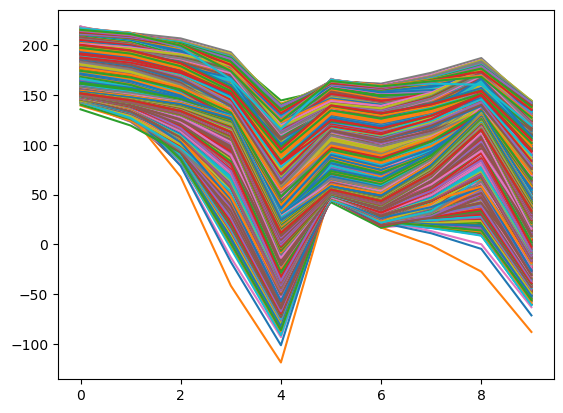

In [37]:
plt.plot(a)

In [22]:
#tie-point model for ice and open water
import numpy as np

def tiepoint(overfladetemperatur,snedybde,istykkelse, iskoncentration):
    #the mar+april 2013 model
    #Tb for sea ice
    #overfladetemperatur [K]
    #snedybde [m]
    #istykkelse [m]
    #iskoncentration [0-1]
    T6vsi  = 151.981 + 0.398 * overfladetemperatur + 23.360  * snedybde - 3.031 * istykkelse
    T6hsi  = 55.262  + 0.687 * overfladetemperatur + 12.962  * snedybde - 1.664 * istykkelse
    T10vsi = 145.878 + 0.435 * overfladetemperatur + 0.743   * snedybde - 4.202 * istykkelse
    T10hsi = 45.107  + 0.753 * overfladetemperatur - 18.7322 * snedybde - 3.490 * istykkelse
    T18vsi = 138.073 + 0.479 * overfladetemperatur - 71.814  * snedybde - 5.570 * istykkelse
    T18hsi = 78.424  + 0.641 * overfladetemperatur - 85.184  * snedybde - 5.341 * istykkelse
    T36vsi = 123.102 + 0.526 * overfladetemperatur - 216.727 * snedybde - 4.036 * istykkelse
    T36hsi = 131.862 + 0.429 * overfladetemperatur - 214.352 * snedybde - 3.035 * istykkelse
    T89vsi = 2.525   + 0.902 * overfladetemperatur - 180.427 * snedybde + 1.904 * istykkelse
    T89hsi = 31.120  + 0.743 * overfladetemperatur - 184.806 * snedybde + 3.197 * istykkelse
    
    T_si = np.array([[T6vsi, T10vsi, T18vsi, T36vsi, T89vsi], [T6hsi, T10hsi, T18hsi, T36hsi, T89hsi]])
    T_ow = np.array([[161.35, 167.34, 183.72, 196.41, 243.20], [82.13, 88.26, 108.46, 128.23, 196.94]])
    
    T_sim = iskoncentration * T_si + (1 - iskoncentration) * T_ow
    
    Tbv = T_sim[0]
    Tbh = T_sim[1]
    
    return Tbv, Tbh

In [23]:
# A range in procentage that creates values from a set standard 

First = tiepoint(np.array([(-1.8 + 273.15), (-1.8 + 273.15)]), np.array([0.16, 0.16]), np.array([0.75, 0.75]), np.array([0.4, 0.5]))
#First = tiepoint(-1.8 + 273.15, 0.16, 0.75, 0.4)

plt.plot(First[0])
plt.plot(First[1], label = '0.5')
plt.legend()

ValueError: operands could not be broadcast together with shapes (2,) (2,5) 

In [118]:
(1-np.array([0.4, 0.5]))*

array([1.2, 1. ])

In [110]:

T_ow = np.array([[161.35, 167.34, 183.72, 196.41, 243.20],[82.13, 88.26, 108.46, 128.23, 196.94]])
T_ow

array([[161.35, 167.34, 183.72, 196.41, 243.2 ],
       [ 82.13,  88.26, 108.46, 128.23, 196.94]])

In [186]:
overfladetemperatur = np.array([(-1.8 + 273.15), (-1.8 + 273.15)])
snedybde = np.array([0.16, 0.26])
istykkelse = np.array([0.75, 0.75])
iskoncentration = np.array([[0.4, 0.5]])
                                
T6vsi  = 151.981 + 0.398 * overfladetemperatur + 23.360  * snedybde - 3.031 * istykkelse
T6hsi  = 55.262  + 0.687 * overfladetemperatur + 12.962  * snedybde - 1.664 * istykkelse
T10vsi = 145.878 + 0.435 * overfladetemperatur + 0.743   * snedybde - 4.202 * istykkelse
T10hsi = 45.107  + 0.753 * overfladetemperatur - 18.7322 * snedybde - 3.490 * istykkelse
T18vsi = 138.073 + 0.479 * overfladetemperatur - 71.814  * snedybde - 5.570 * istykkelse
T18hsi = 78.424  + 0.641 * overfladetemperatur - 85.184  * snedybde - 5.341 * istykkelse
T36vsi = 123.102 + 0.526 * overfladetemperatur - 216.727 * snedybde - 4.036 * istykkelse
T36hsi = 131.862 + 0.429 * overfladetemperatur - 214.352 * snedybde - 3.035 * istykkelse
T89vsi = 2.525   + 0.902 * overfladetemperatur - 180.427 * snedybde + 1.904 * istykkelse
T89hsi = 31.120  + 0.743 * overfladetemperatur - 184.806 * snedybde + 3.197 * istykkelse

T_si = np.array([[T6vsi, T10vsi, T18vsi, T36vsi, T89vsi], [T6hsi, T10hsi, T18hsi, T36hsi, T89hsi]])
T_ow = np.array([[161.35, 167.34, 183.72, 196.41, 243.20], [82.13, 88.26, 108.46, 128.23, 196.94]])


iskoncentration * T_si

array([[[104.57706  , 131.889325 ],
        [104.353052 , 130.478465 ],
        [100.952764 , 122.600255 ],
        [ 91.251512 , 103.22804  ],
        [ 87.936952 , 100.89984  ]],

       [[ 97.002148 , 121.900785 ],
        [ 97.5275592, 120.972839 ],
        [ 93.889664 , 113.10288  ],
        [ 84.679432 ,  95.13169  ],
        [ 82.224736 ,  93.54062  ]]])

In [189]:
np.shape(iskoncentration * T_ow.T)
print(iskoncentration.T * T_ow)

[[64.54  66.936 73.488 78.564 97.28 ]
 [41.065 44.13  54.23  64.115 98.47 ]]


In [169]:
np.shape(iskoncentration.T)

(2,)

In [177]:
print(T_si)

[[[261.44265  242.50537 ]
  [260.88263  243.818898]
  [252.38191  234.72416 ]
  [228.12878  211.69858 ]
  [219.84238  205.56184 ]]

 [[263.77865  243.80157 ]
  [260.95693  241.945678]
  [245.20051  226.20576 ]
  [206.45608  190.26338 ]
  [201.79968  187.08124 ]]]


In [181]:
T_ow.T

array([[161.35,  82.13],
       [167.34,  88.26],
       [183.72, 108.46],
       [196.41, 128.23],
       [243.2 , 196.94]])

In [188]:
np.array([[0.4, 0.5]])


array([[0.4, 0.5]])